In [1]:
import tensorflow as tf
import pandas as pd
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
from IPython import display

In [2]:
data = pd.read_pickle("./FinalFormulas.pkl")

In [3]:
values = data.index.values
last_5 = values[-int(0.05*len(values))]
validation_data = data[(data.index >= last_5)]
data = data[(data.index < last_5)]

In [4]:
test = validation_data
train = data

print(f"train length: {len(train)}")
print(f"test length: {len(test)}")

train length: 15563
test length: 819


In [5]:
print(train[0:2])

                                             Formula
0  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....
1  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....


In [6]:
train_list = []
for i in train.values:
    temp = []
    i.tolist()
    train_list.append(i)
test_list = []
for i in test.values:
    temp = []
    i.tolist()
    test_list.append(i)

In [7]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(
                tf.cast(train_list, tf.float32)
            ).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(
                tf.cast(test_list, tf.float32)
            ).shuffle(TEST_BUF).batch(BATCH_SIZE)


In [24]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(118,1)),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dropout(rate=0.3),
          tf.keras.layers.Dense(units=118, activation=tf.nn.relu),
          tf.keras.layers.Dropout(rate=0.3),
          tf.keras.layers.Dense(units=118, activation=tf.nn.tanh),
          tf.keras.layers.Dropout(rate=0.3),
          tf.keras.layers.Dense(units=118, activation=tf.nn.softmax),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dropout(rate=0.3),
          tf.keras.layers.Dense(units=118, activation=tf.nn.relu),
          tf.keras.layers.Dropout(rate=0.3),
          tf.keras.layers.Dense(units=236, activation=tf.nn.tanh),
          tf.keras.layers.Dropout(rate=0.3),
          tf.keras.layers.Dense(units=118, activation=tf.nn.softmax),

          tf.keras.layers.Reshape(target_shape=(118,1))
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [25]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [26]:
epochs = 1
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [27]:
def generate_and_save_images(model, epoch, test_input, string):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :], cmap='gray')
        plt.axis('off')

    _ = "gen_formulas/formulas" + string + ".txt"
    f = open(_, "w+")
    
    for i in range(predictions.shape[0]):
        f.write("%s\n" % str(predictions[i]))
    f.close()
      # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('gen_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Epoch: 1, Test set ELBO: -79.95368194580078, time elapse for current epoch 2.359109878540039


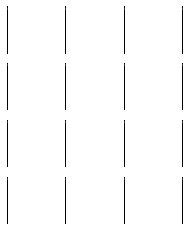

In [28]:
generate_and_save_images(model, 0, random_vector_for_generation, "0")

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_x = np.asarray(train_x).reshape(-1,118,1)
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      test_x = np.asarray(test_x).reshape(-1,118,1)
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation, str(epoch))

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

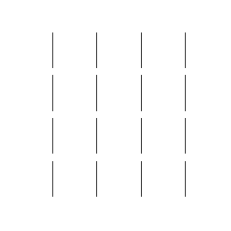

In [64]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images